In [17]:
#CODE FOR GENERATING VIDEOS FROM TIFFS

import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import cv2

# New directory containing the TIFF files
base_directory = r'C:\Users\josep\Desktop\20240703 48 hour time lapse\TIFFs nonPEG wells\20240707T182811'

# Experiments details
experiments = {
    "D-10": 7,
    "E-09": 12,
    "E-11": 12,
    "F-10": 12,
    "F-11": 12
}

# Parameters
num_frames = 192
frame_rate = 8  # 8 frames per second for the movie
time_interval = 15 / 60  # 15 minutes in hours
scale_bar_length = 100  # in micrometers
scale_pixels_per_um = 3.074 * 2  # updated due to binning of 2
scale_bar_pixel_length = int(scale_bar_length * scale_pixels_per_um)
image_width = 990
image_height = 990

# Standardized LUT settings
lower_limit = 27.0
upper_limit = 933.0

# Lower threshold for Canny edge detection
edge_lower_threshold = 10
edge_upper_threshold = 100

# Auto-adjust intensity using standardized LUT settings
def auto_adjust_intensity(image, lower_limit, upper_limit):
    np_image = np.array(image)
    np_image = np.clip(np_image, lower_limit, upper_limit)
    np_image = ((np_image - lower_limit) / (upper_limit - lower_limit) * 255).astype(np.uint8)  # Scale to 8-bit
    return Image.fromarray(np_image)

# Generate masks from the image using improved settings for membrane mask
def generate_masks(image, lower_limit, upper_limit):
    np_image = np.array(image).astype(np.uint8)  # Ensure image is in 8-bit format

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(np_image, (5, 5), 0)
    
    # Generate colony mask using thresholding and contour detection
    _, colony_mask = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(colony_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    colony_mask = np.zeros_like(colony_mask)
    cv2.drawContours(colony_mask, contours, -1, (255), thickness=cv2.FILLED)
    
    # Adjust the Canny edge detection thresholds relative to the intensity range
    edge_lower_threshold_adj = int((edge_lower_threshold / 255.0) * (upper_limit - lower_limit) + lower_limit)
    edge_upper_threshold_adj = int((edge_upper_threshold / 255.0) * (upper_limit - lower_limit) + lower_limit)
    
    # Generate membrane mask using edge detection and morphological operations
    edges = cv2.Canny(blurred, edge_lower_threshold_adj, edge_upper_threshold_adj)
    kernel = np.ones((3, 3), np.uint8)
    membrane_mask = cv2.dilate(edges, kernel, iterations=1)
    membrane_mask = cv2.erode(membrane_mask, kernel, iterations=1)
    membrane_mask = cv2.morphologyEx(membrane_mask, cv2.MORPH_CLOSE, kernel)
    
    # Generate non-membrane mask by subtracting membrane mask from colony mask
    non_mem_mask = cv2.subtract(colony_mask, membrane_mask)
    
    return Image.fromarray(colony_mask), Image.fromarray(membrane_mask), Image.fromarray(non_mem_mask)

# Add scale bar and time stamp to image
def add_scale_and_time(image, time_text):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("arial.ttf", 120)
    except IOError:
        font = ImageFont.load_default()
    draw.rectangle([(image.width - scale_bar_pixel_length - 10, image.height - 20), 
                    (image.width - 10, image.height - 10)], fill="white")
    text_size = draw.textsize(time_text, font=font)
    draw.text((image.width - text_size[0] - 10, 10), time_text, fill="white", font=font)
    return image

# Load and process the images
def load_and_process_image(file_path, lower_limit, upper_limit, time_text):
    image = Image.open(file_path)
    adjusted_image = auto_adjust_intensity(image, lower_limit, upper_limit)
    
    # Generate masks with dynamic edge detection thresholds
    colony_mask, membrane_mask, non_mem_mask = generate_masks(adjusted_image, lower_limit, upper_limit)
    
    # Apply non-membrane mask
    image_np = np.array(adjusted_image)
    non_mem_image = Image.fromarray(image_np * (np.array(non_mem_mask) // 255))
    
    # Add scale bar and time stamp to each image
    adjusted_image = add_scale_and_time(adjusted_image, time_text)
    colony_mask_img = add_scale_and_time(colony_mask, time_text)
    membrane_mask_img = add_scale_and_time(membrane_mask, time_text)
    non_mem_image = add_scale_and_time(non_mem_image, time_text)
    
    return adjusted_image, non_mem_image, colony_mask_img, membrane_mask_img, non_mem_mask

# Create the videos
def create_videos():
    for experiment, num_fields in experiments.items():
        # Add lower threshold to the directory name
        exp_directory = os.path.join(base_directory, f'{experiment}_lower_thresh_{edge_lower_threshold}')
        os.makedirs(exp_directory, exist_ok=True)
        for f in range(1, num_fields + 1):
            five_panel_video_file = os.path.join(exp_directory, f'five_panel_movie_F{f:04d}.avi')
            non_mem_b_cat_video_file = os.path.join(exp_directory, f'non_mem_b_cat_movie_F{f:04d}.avi')
            fourcc = cv2.VideoWriter_fourcc(*'MJPG')
            five_panel_video = cv2.VideoWriter(five_panel_video_file, fourcc, frame_rate, (image_width * 3, image_height * 2))  # 5 panels
            non_mem_b_cat_video = cv2.VideoWriter(non_mem_b_cat_video_file, fourcc, frame_rate, (image_width, image_height))
            previous_image = None
            for t in range(1, num_frames + 1):
                image_path = os.path.join(base_directory, f'{experiment}_F{f:04d}_T{t:04d}_Z0001_C01.tif')
                time_text = f'{(t - 1) * time_interval:.2f} hrs'
                if os.path.exists(image_path):
                    adjusted_image, non_mem_image, colony_mask_img, membrane_mask_img, non_mem_mask_img = load_and_process_image(image_path, lower_limit, upper_limit, time_text)
                    previous_image = (adjusted_image, non_mem_image, colony_mask_img, membrane_mask_img, non_mem_mask_img)
                else:
                    if previous_image:
                        adjusted_image, non_mem_image, colony_mask_img, membrane_mask_img, non_mem_mask_img = previous_image
                    else:
                        adjusted_image = Image.new('L', (image_width, image_height))
                        non_mem_image = Image.new('L', (image_width, image_height))
                        colony_mask_img = Image.new('L', (image_width, image_height))
                        membrane_mask_img = Image.new('L', (image_width, image_height))
                        non_mem_mask_img = Image.new('L', (image_width, image_height))
                        adjusted_image, non_mem_image, colony_mask_img, membrane_mask_img, non_mem_mask_img = add_scale_and_time(adjusted_image, time_text), add_scale_and_time(non_mem_image, time_text), add_scale_and_time(colony_mask_img, time_text), add_scale_and_time(membrane_mask_img, time_text), add_scale_and_time(non_mem_mask_img, time_text)
                adjusted_image_rgb = Image.merge("RGB", (adjusted_image, adjusted_image, adjusted_image))
                colony_mask_rgb = Image.merge("RGB", (colony_mask_img, colony_mask_img, colony_mask_img))
                membrane_mask_rgb = Image.merge("RGB", (membrane_mask_img, membrane_mask_img, membrane_mask_img))
                non_mem_mask_rgb = Image.merge("RGB", (non_mem_mask_img, non_mem_mask_img, non_mem_mask_img))
                non_mem_image_rgb = Image.merge("RGB", (non_mem_image, non_mem_image, non_mem_image))
                composite_image = Image.new('RGB', (image_width * 3, image_height * 2))
                composite_image.paste(adjusted_image_rgb, (0, 0))
                composite_image.paste(colony_mask_rgb, (image_width, 0))
                composite_image.paste(membrane_mask_rgb, (image_width * 2, 0))
                composite_image.paste(non_mem_mask_rgb, (0, image_height))
                composite_image.paste(non_mem_image_rgb, (image_width, image_height))
                draw = ImageDraw.Draw(composite_image)
                font_size = 80
                try:
                    font = ImageFont.truetype("arial.ttf", font_size)
                except IOError:
                    font = ImageFont.load_default()
                draw.text((50, 10), "Adjusted Image", fill="white", font=font)
                draw.text((image_width + 50, 10), "Colony Mask", fill="white", font=font)
                draw.text((2 * image_width + 50, 10), "Membrane Mask", fill="white", font=font)
                draw.text((50, image_height + 10), "Non-Membrane Mask", fill="white", font=font)
                draw.text((image_width + 50, image_height + 10), "Non-Membrane Image", fill="white", font=font)
                composite_np = np.array(composite_image)
                cv_composite_image = cv2.cvtColor(composite_np, cv2.COLOR_RGB2BGR)
                five_panel_video.write(cv_composite_image)
                non_mem_np = np.array(non_mem_image)
                cv_non_mem_image = cv2.cvtColor(non_mem_np, cv2.COLOR_GRAY2BGR)
                non_mem_b_cat_video.write(cv_non_mem_image)
                if t % (num_frames // 4) == 0:
                    print(f"Experiment {experiment}, Field {f}: {t / num_frames * 100:.0f}% completed.")
            five_panel_video.release()
            non_mem_b_cat_video.release()
            print(f"Experiment {experiment}, Field {f}: Both videos created successfully!")

# Create the videos
create_videos()

print("All videos created successfully!")


Experiment D-10, Field 1: 25% completed.
Experiment D-10, Field 1: 50% completed.
Experiment D-10, Field 1: 75% completed.
Experiment D-10, Field 1: 100% completed.
Experiment D-10, Field 1: Both videos created successfully!
Experiment D-10, Field 2: 25% completed.
Experiment D-10, Field 2: 50% completed.
Experiment D-10, Field 2: 75% completed.
Experiment D-10, Field 2: 100% completed.
Experiment D-10, Field 2: Both videos created successfully!
Experiment D-10, Field 3: 25% completed.
Experiment D-10, Field 3: 50% completed.
Experiment D-10, Field 3: 75% completed.
Experiment D-10, Field 3: 100% completed.
Experiment D-10, Field 3: Both videos created successfully!
Experiment D-10, Field 4: 25% completed.
Experiment D-10, Field 4: 50% completed.
Experiment D-10, Field 4: 75% completed.
Experiment D-10, Field 4: 100% completed.
Experiment D-10, Field 4: Both videos created successfully!
Experiment D-10, Field 5: 25% completed.
Experiment D-10, Field 5: 50% completed.
Experiment D-10, F

In [2]:
#VIDEO S1
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.cm import get_cmap
from matplotlib.cm import viridis


# Load the CSV file
csv_file_path = 'kymograph_data.csv'
data = pd.read_csv(csv_file_path)

# Extract the bin data, ignoring the first three columns
bin_data = data.iloc[:, 3:].values

# Calculate the 25th and 75th percentiles for the entire dataset
percentile_25 = np.percentile(bin_data, 25)
percentile_75 = np.percentile(bin_data, 75)

# Normalize the data using the 25th and 75th percentile values
normalized_data = (bin_data - percentile_25) / (percentile_75 - percentile_25)

# Add normalized data back to the DataFrame
data.iloc[:, 3:] = normalized_data

# Set normalization for colormap
norm = Normalize(vmin=0, vmax=1.5)
sm = ScalarMappable(cmap='jet', norm=norm)

# Base directory containing the TIFF files
base_directory = r'C:\Users\josep\Desktop\20240703 48 hour time lapse\TIFFs nonPEG wells\20240707T182811'
output_directory = os.path.join(base_directory, "videos for paper")
os.makedirs(output_directory, exist_ok=True)

# Fields to process
fields_to_process = {
    "E-09": 3,
    "F-10": 9,
    "E-11": 1
}

# Parameters
num_frames = 192
frame_rate = 16  # 16 frames per second for the movie
time_interval = 15 / 60  # 15 minutes in hours
scale_pixels_per_um = 3.074 / 2  # corrected due to binning of 2
scale_bar_pixel_length = int(100 * scale_pixels_per_um)  # scale bar length in pixels
image_width = 990
image_height = 990

# Standardized LUT settings
lower_limit = 27.0
upper_limit = 933.0

# Lower threshold for Canny edge detection
edge_lower_threshold = 10
edge_upper_threshold = 100

# Auto-adjust intensity using standardized LUT settings
def auto_adjust_intensity(image, lower_limit, upper_limit):
    np_image = np.array(image)
    np_image = np.clip(np_image, lower_limit, upper_limit)
    np_image = ((np_image - lower_limit) / (upper_limit - lower_limit) * 255).astype(np.uint8)  # Scale to 8-bit
    return Image.fromarray(np_image)

# Generate masks from the image using the proper colony mask implementation
def generate_masks(image, lower_limit, upper_limit):
    np_image = np.array(image).astype(np.uint8)  # Ensure image is in 8-bit format

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(np_image, (5, 5), 0)
    
    # Generate colony mask using thresholding and contour detection
    _, colony_mask = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(colony_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    colony_mask = np.zeros_like(colony_mask)
    cv2.drawContours(colony_mask, contours, -1, (255), thickness=cv2.FILLED)
    
    # Adjust the Canny edge detection thresholds relative to the intensity range
    edge_lower_threshold_adj = int((edge_lower_threshold / 255.0) * (upper_limit - lower_limit) + lower_limit)
    edge_upper_threshold_adj = int((edge_upper_threshold / 255.0) * (upper_limit - lower_limit) + lower_limit)
    
    # Generate membrane mask using edge detection and morphological operations
    edges = cv2.Canny(blurred, edge_lower_threshold_adj, edge_upper_threshold_adj)
    kernel = np.ones((3, 3), np.uint8)
    membrane_mask = cv2.dilate(edges, kernel, iterations=1)
    membrane_mask = cv2.erode(membrane_mask, kernel, iterations=1)
    membrane_mask = cv2.morphologyEx(membrane_mask, cv2.MORPH_CLOSE, kernel)
    
    # Generate non-membrane mask by subtracting membrane mask from colony mask
    non_mem_mask = cv2.subtract(colony_mask, membrane_mask)
    
    return Image.fromarray(non_mem_mask)

# Apply colormap to image using normalized data
def apply_colormap(image, normalized_data, sm):
    image_np = np.array(image).astype(np.float32)
    normalized_image = (image_np - percentile_25) / (percentile_75 - percentile_25)
    normalized_image = np.clip(normalized_image, 0, 1.5)
    colored_image = sm.to_rgba(normalized_image, bytes=True)
    return Image.fromarray(colored_image)

# Add titles, scale bars, and time stamps to each panel
def annotate_panel(image, title_text, time_text):
    draw = ImageDraw.Draw(image)
    try:
        font_title = ImageFont.truetype("arial.ttf", 40)
        font_time = ImageFont.truetype("arial.ttf", 30)
    except IOError:
        font_title = ImageFont.load_default()
        font_time = ImageFont.load_default()
    
    # Add title
    draw.text((10, 10), title_text, fill="white", font=font_title)
    
    # Add time stamp in the lower left
    text_size = draw.textsize(time_text, font=font_time)
    draw.text((10, image.height - text_size[1] - 10), time_text, fill="white", font=font_time)
    
    # Add scale bar
    draw.rectangle([(image.width - scale_bar_pixel_length - 10, image.height - 20), 
                    (image.width - 10, image.height - 10)], fill="white")
    
    return image

# Load and process the images with colormap
def load_and_process_image(file_path, lower_limit, upper_limit, sm):
    image = Image.open(file_path)
    adjusted_image = auto_adjust_intensity(image, lower_limit, upper_limit)
    
    # Generate non-membrane mask
    non_mem_mask = generate_masks(adjusted_image, lower_limit, upper_limit)
    
    # Apply non-membrane mask
    image_np = np.array(adjusted_image)
    non_mem_image = Image.fromarray(image_np * (np.array(non_mem_mask) // 255))
    
    # Apply the colormap
    colored_image = apply_colormap(non_mem_image, normalized_data, sm)
    
    return colored_image

# Create the 3-panel video
def create_3_panel_video():
    video_file = os.path.join(output_directory, '3_panel_video_colored_jet.avi')
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    video = cv2.VideoWriter(video_file, fourcc, frame_rate, (image_width * 3, image_height))
    
    for t in range(1, num_frames + 1):
        panels = []
        for experiment, field in fields_to_process.items():
            image_path = os.path.join(base_directory, f'{experiment}_F{field:04d}_T{t:04d}_Z0001_C01.tif')
            time_text = f'{(t - 1) * time_interval:.2f} hrs'
            if os.path.exists(image_path):
                colored_image = load_and_process_image(image_path, lower_limit, upper_limit, sm)
                
                if experiment == "E-09":
                    title_text = "Low cell density: 802 cells"
                elif experiment == "F-10":
                    title_text = "Medium cell density: 881 cells"
                elif experiment == "E-11":
                    title_text = "High cell density: 923 cells"
                
                annotated_image = annotate_panel(colored_image, title_text, time_text)
                panels.append(annotated_image)
            else:
                panels.append(Image.new('L', (image_width, image_height)))
        
        # Combine the three panels into a single composite image
        composite_image = Image.new('RGB', (image_width * 3, image_height))
        for i, panel in enumerate(panels):
            composite_image.paste(panel.convert('RGB'), (i * image_width, 0))
        
        # Save composite frame to video
        composite_np = np.array(composite_image)
        cv_composite_image = cv2.cvtColor(composite_np, cv2.COLOR_RGB2BGR)
        video.write(cv_composite_image)
        
        if t % (num_frames // 4) == 0:
            print(f"Frame {t / num_frames * 100:.0f}% completed.")
    
    video.release()
    print("3-panel video created successfully!")

# Create the 3-panel video
create_3_panel_video()

Frame 25% completed.
Frame 50% completed.
Frame 75% completed.
Frame 100% completed.
3-panel video created successfully!


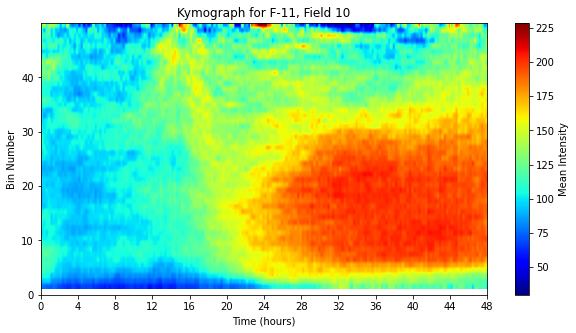

In [60]:
#CREATE SINGLE KYMOGRAPH

import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Parameters
scale_pixels_per_um = 3.074 / 2  # corrected due to binning of 2
frame_interval_minutes = 15  # 15 minutes per frame
num_frames = 192
total_duration_hours = frame_interval_minutes * num_frames / 60

# Standardized LUT settings
lower_limit = 27.0
upper_limit = 933.0

# Lower threshold for Canny edge detection
edge_lower_threshold = 10
edge_upper_threshold = 100

# Auto-adjust intensity using standardized LUT settings
def auto_adjust_intensity(image, lower_limit, upper_limit):
    np_image = np.array(image)
    np_image = np.clip(np_image, lower_limit, upper_limit)
    np_image = ((np_image - lower_limit) / (upper_limit - lower_limit) * 255).astype(np.uint8)  # Scale to 8-bit
    return Image.fromarray(np_image)

# Generate masks from the image using improved settings for membrane mask
def generate_masks(image):
    # Convert image to numpy array
    np_image = np.array(image).astype(np.uint8)  # Ensure image is in 8-bit format
    
    # Intensity adjustment
    intensity_adjusted_image = auto_adjust_intensity(image, lower_limit, upper_limit)
    np_image = np.array(intensity_adjusted_image)

    # Identify the primary circle
    blurred = cv2.GaussianBlur(np_image, (5, 5), 0)
    _, colony_mask = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(colony_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    main_contour = max(contours, key=cv2.contourArea)
    ellipse = cv2.fitEllipse(main_contour)
    (x, y), (major_axis, minor_axis), angle = ellipse
    center = (x, y)
    radius = major_axis / 2
    
    colony_mask = np.zeros_like(np_image)
    cv2.circle(colony_mask, (int(center[0]), int(center[1])), int(radius), 255, thickness=-1)
    
    # Adjust the Canny edge detection thresholds relative to the intensity range
    edge_lower_threshold_adj = int((edge_lower_threshold / 255.0) * (upper_limit - lower_limit) + lower_limit)
    edge_upper_threshold_adj = int((edge_upper_threshold / 255.0) * (upper_limit - lower_limit) + lower_limit)
    
    # Generate membrane mask using edge detection and morphological operations
    edges = cv2.Canny(blurred, edge_lower_threshold_adj, edge_upper_threshold_adj)
    kernel = np.ones((3, 3), np.uint8)
    membrane_mask = cv2.dilate(edges, kernel, iterations=1)
    membrane_mask = cv2.erode(membrane_mask, kernel, iterations=1)
    membrane_mask = cv2.morphologyEx(membrane_mask, cv2.MORPH_CLOSE, kernel)
    
    # Generate non-membrane mask by subtracting membrane mask from colony mask
    non_mem_mask = cv2.subtract(colony_mask, membrane_mask)
    
    return Image.fromarray(colony_mask), Image.fromarray(membrane_mask), Image.fromarray(non_mem_mask), center, radius

# Load and process the image for analysis
def load_and_process_image_for_analysis(file_path, non_mem_mask, lower_limit, upper_limit):
    image = Image.open(file_path)
    adjusted_image = auto_adjust_intensity(image, lower_limit, upper_limit)
    
    # Apply non-membrane mask
    image_np = np.array(adjusted_image)
    non_mem_image = Image.fromarray(image_np * (np.array(non_mem_mask) // 255))
    
    return adjusted_image, non_mem_image

# Identify main circular object and create radial bins
def analyze_image(non_mem_image, non_mem_mask, center, radius):
    # Define bin sizes based on the detected radius
    bins = 50
    radial_bins = np.linspace(0, radius, bins + 1)
    
    mean_intensities = []

    non_mem_np = np.array(non_mem_image)
    non_mem_mask_np = np.array(non_mem_mask)
    
    for i in range(bins):
        inner_radius = radial_bins[i]
        outer_radius = radial_bins[i + 1]
        
        # Create a mask for the current bin
        mask = np.zeros_like(non_mem_np, dtype=np.uint8)
        cv2.circle(mask, (int(center[0]), int(center[1])), int(outer_radius), 1, thickness=-1)
        cv2.circle(mask, (int(center[0]), int(center[1])), int(inner_radius), 0, thickness=-1)
        
        # Apply mask to the non-membrane image
        bin_pixels = non_mem_np[mask == 1]
        bin_mask = non_mem_mask_np[mask == 1]
        non_zero_bin_pixels = bin_pixels[bin_mask > 0]  # Exclude zero-value pixels from the non-membrane mask
        if len(non_zero_bin_pixels) > 0:
            mean_intensity = np.mean(non_zero_bin_pixels)
        else:
            mean_intensity = 0
        
        mean_intensities.append(mean_intensity)
    
    return mean_intensities

# Main analysis function for all frames
def analyze_all_frames():
    base_directory = r'C:\Users\josep\Desktop\20240703 48 hour time lapse\TIFFs nonPEG wells\20240707T182811'
    experiment = 'F-11'
    field = 10
    num_frames = 192

    kymograph_data = []

    for frame in range(1, num_frames + 1):
        image_path = os.path.join(base_directory, f'{experiment}_F{field:04d}_T{frame:04d}_Z0001_C01.tif')
        
        if os.path.exists(image_path):
            # Load original image
            original_image = Image.open(image_path)
            # Generate masks for the current frame
            colony_mask, membrane_mask, non_mem_mask, center, radius = generate_masks(original_image)
            # Process image with non-membrane mask
            adjusted_image, non_mem_image = load_and_process_image_for_analysis(image_path, np.array(non_mem_mask), lower_limit, upper_limit)
            
            # Perform analysis
            mean_intensities = analyze_image(non_mem_image, non_mem_mask, center, radius)
            kymograph_data.append(mean_intensities)
        else:
            print(f"Image {image_path} does not exist.")
            # Append zeros if the image does not exist
            kymograph_data.append([0] * 50)
    
    # Convert kymograph data to numpy array and transpose it
    kymograph = np.array(kymograph_data).T

    fig, ax = plt.subplots(figsize=(10, 5))
    time_points = np.linspace(0, total_duration_hours, num_frames)
    cax = ax.imshow(kymograph, aspect='auto', cmap='jet', extent=[0, total_duration_hours, 1, 50])
    ax.set_yticks(np.arange(0, 50, 10))  # Adjust number of y-ticks to match the number of bins
    ax.set_yticklabels(np.arange(0, 50, 10))
    ax.set_xticks(np.arange(0, total_duration_hours + 1, 4))  # Set x-ticks to represent every 4 hours
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Bin Number')
    ax.set_title('Kymograph for F-11, Field 10')
    fig.colorbar(cax, label='Mean Intensity')
    plt.show()

# Perform the analysis
analyze_all_frames()

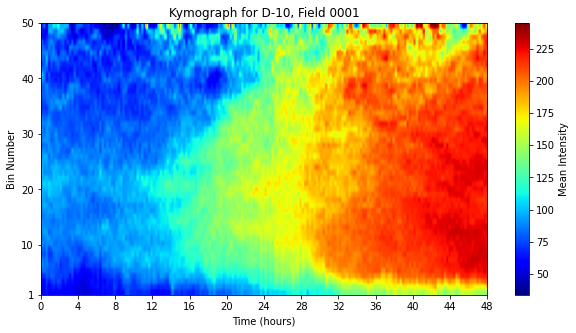

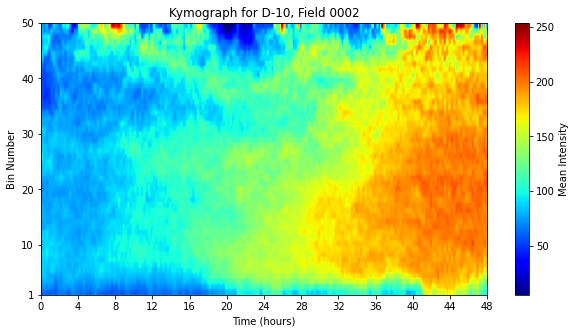

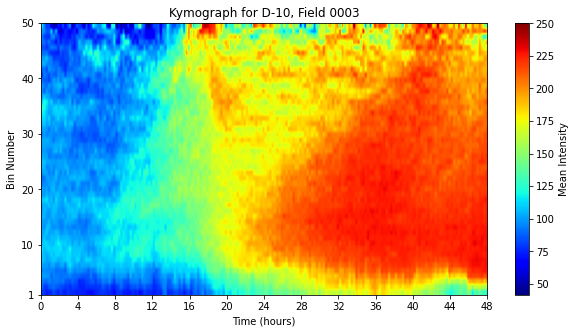

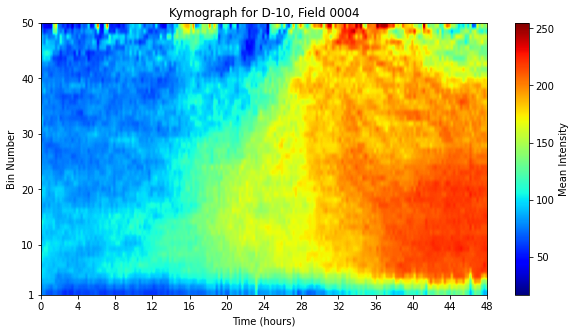

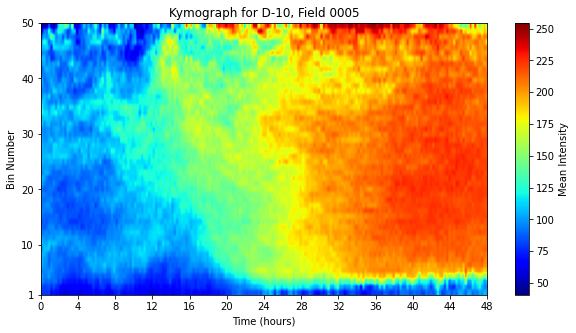

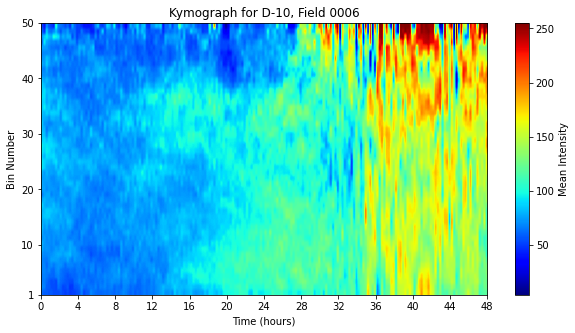

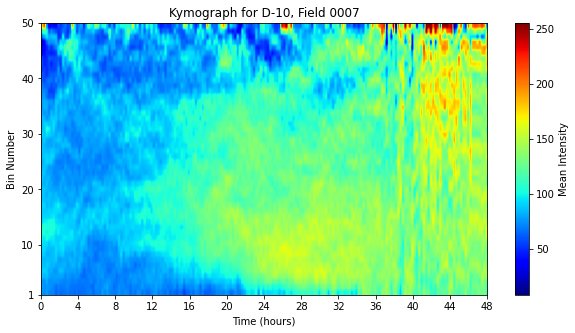

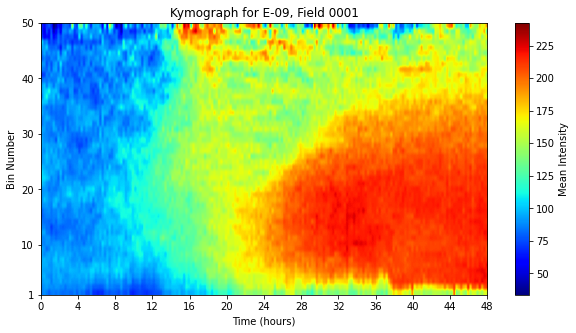

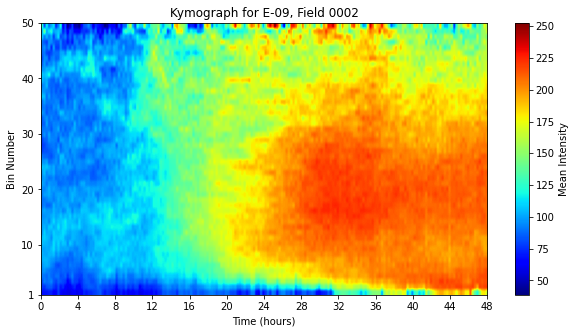

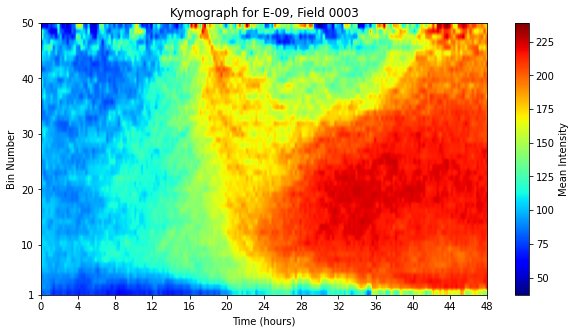

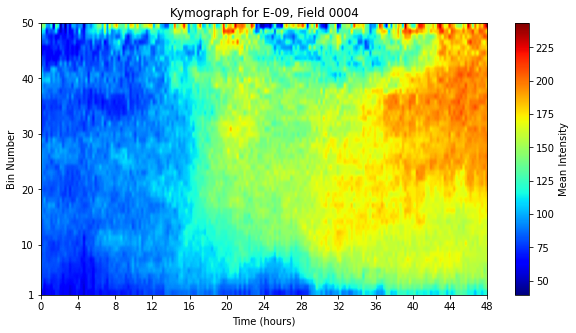

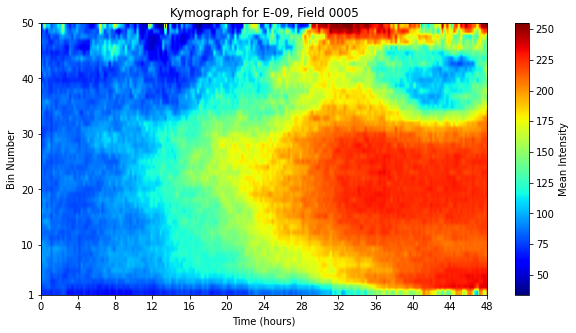

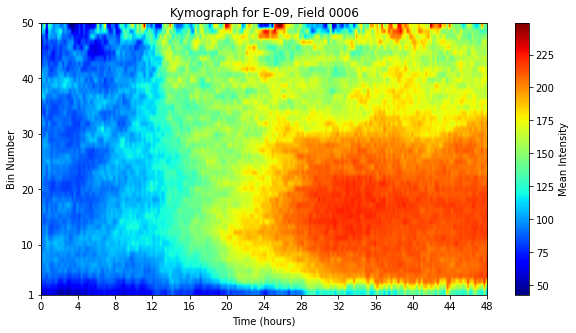

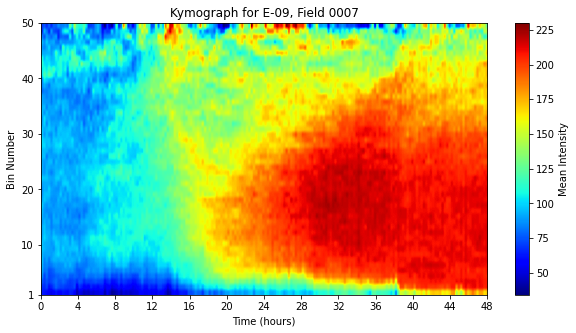

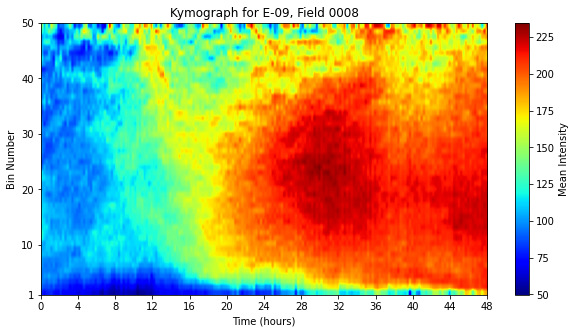

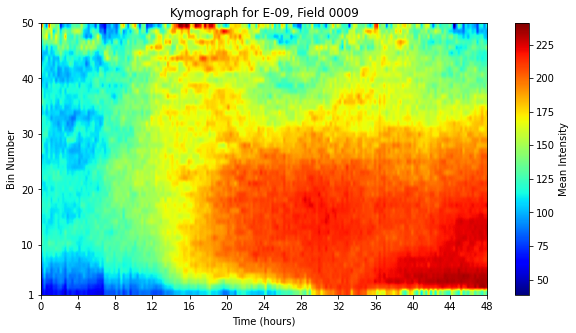

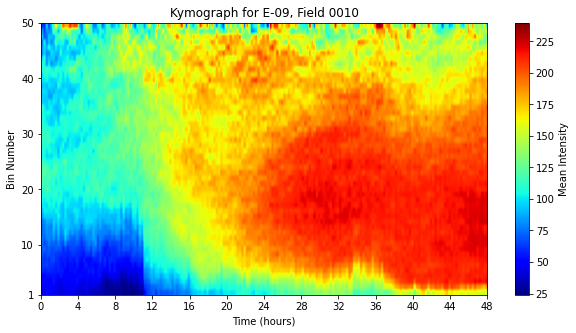

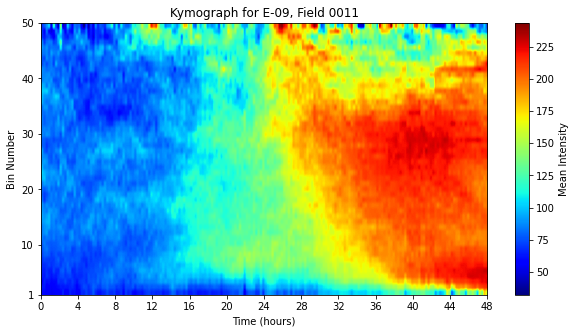

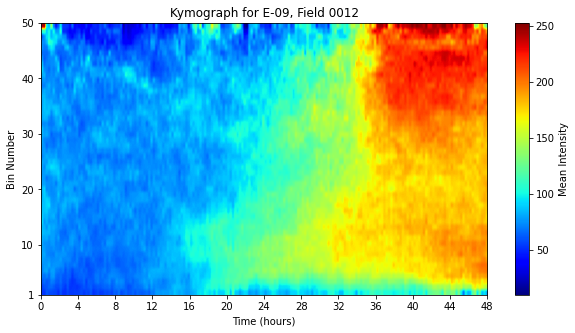

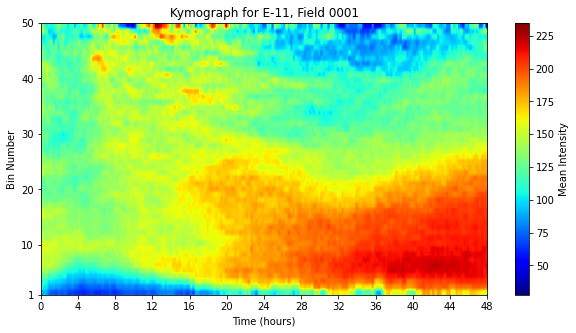

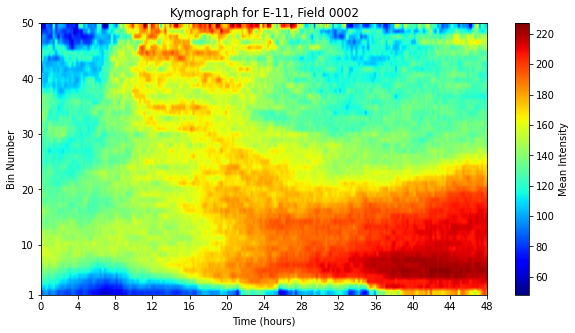

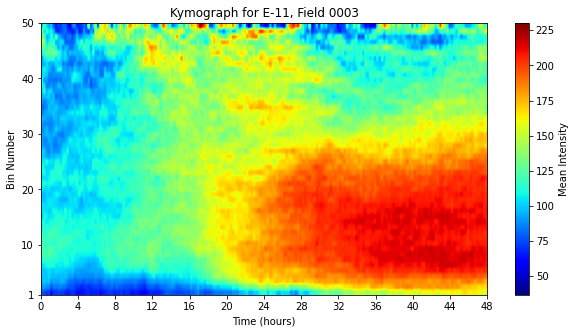

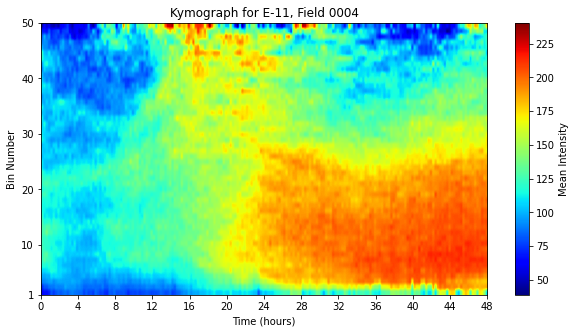

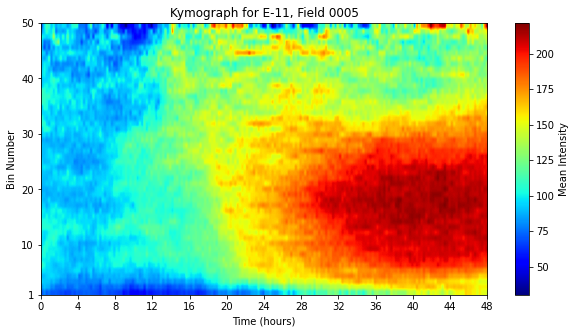

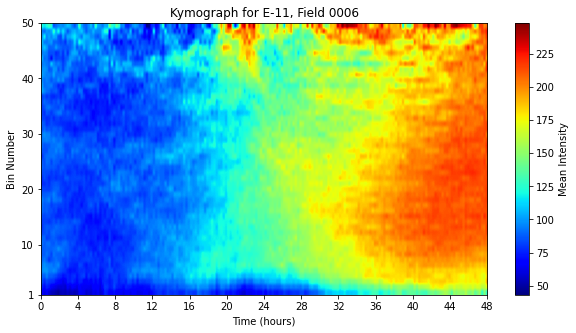

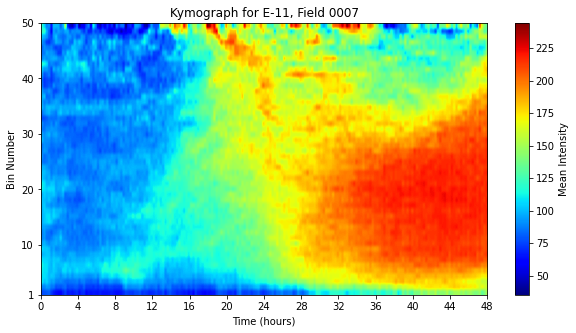

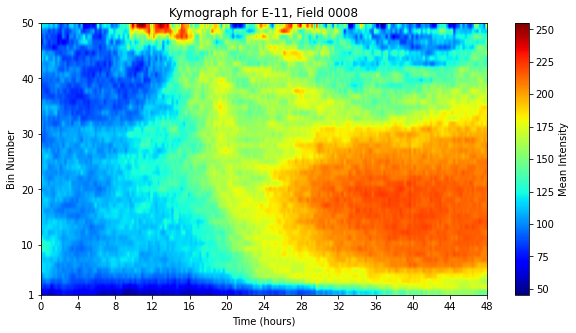

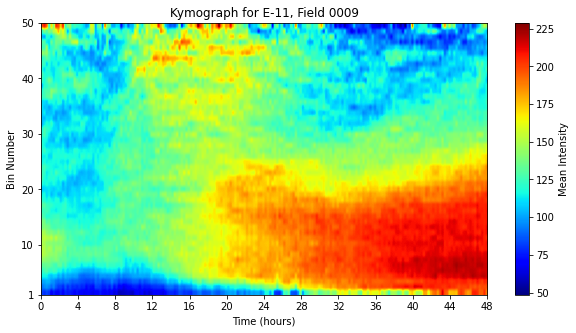

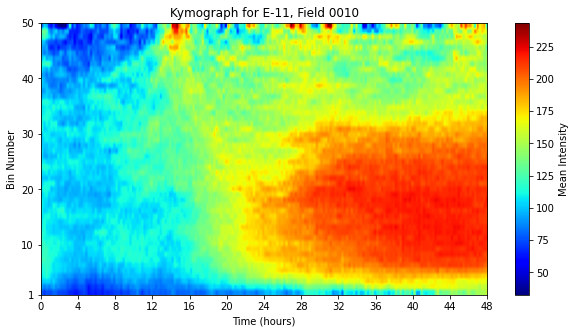

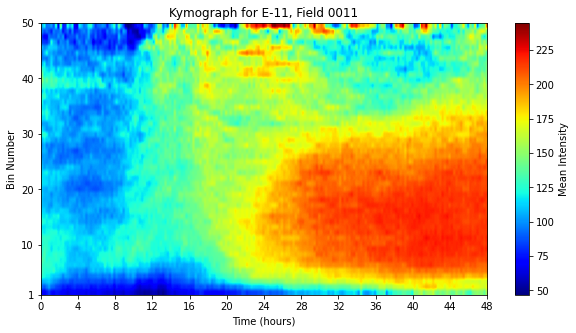

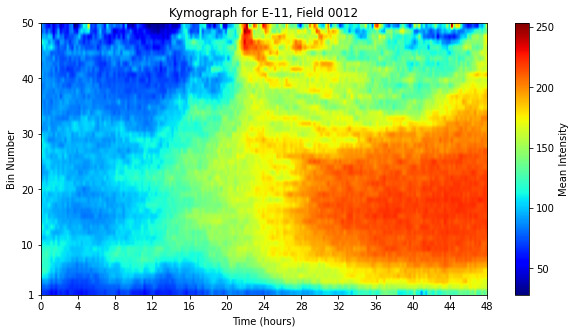

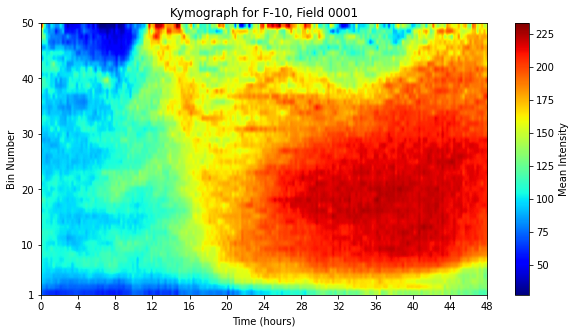

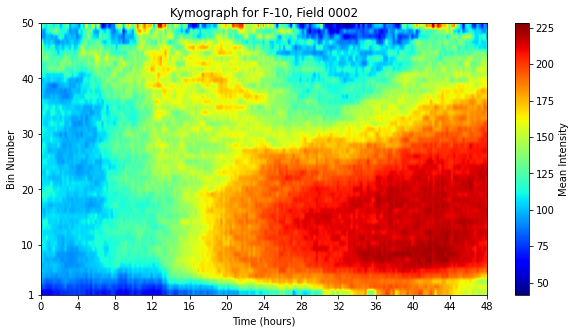

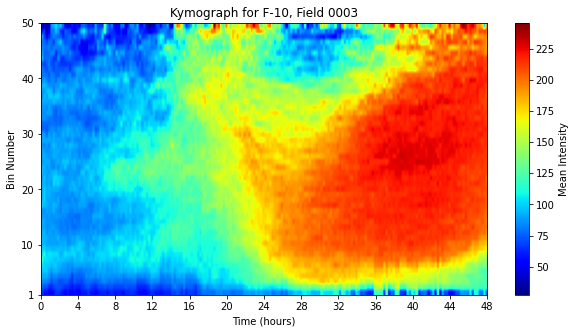

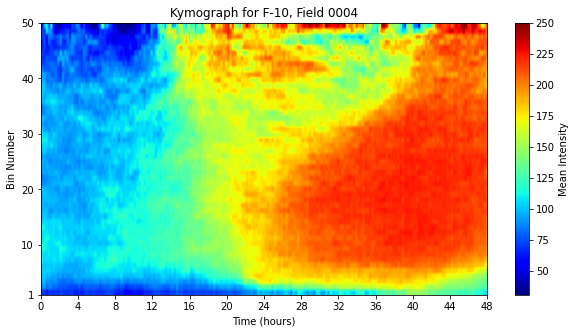

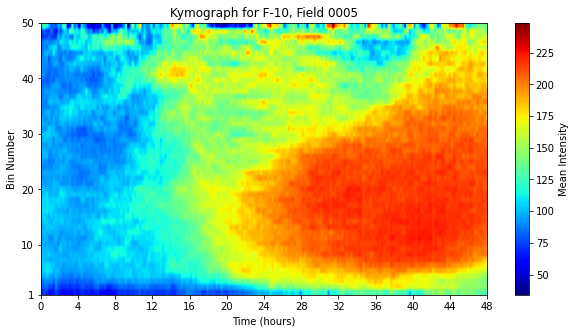

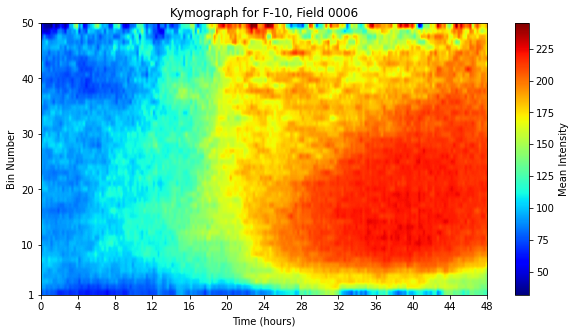

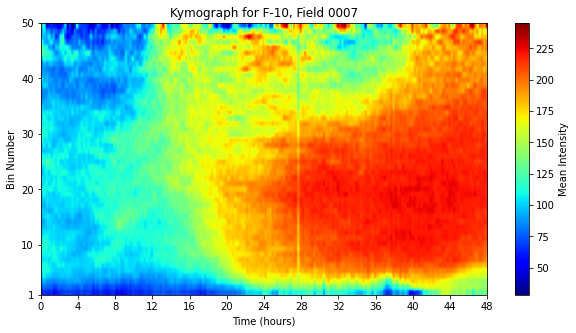

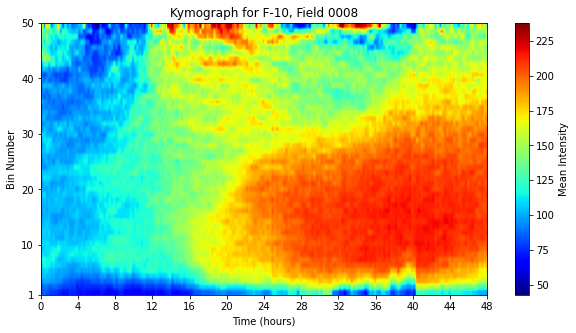

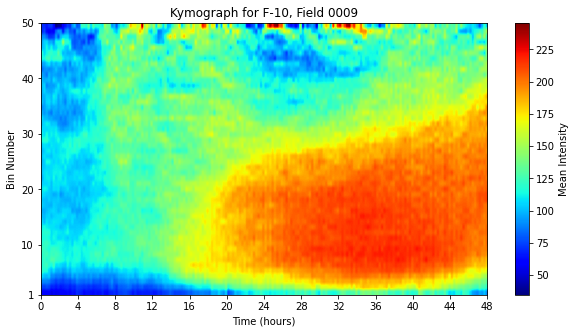

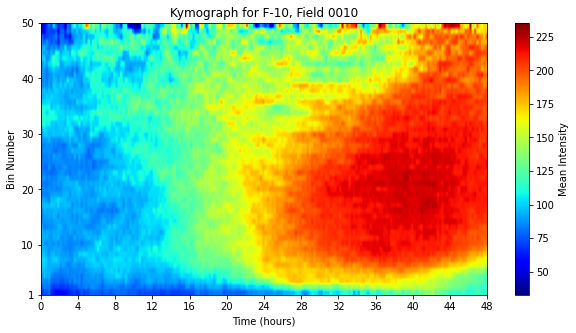

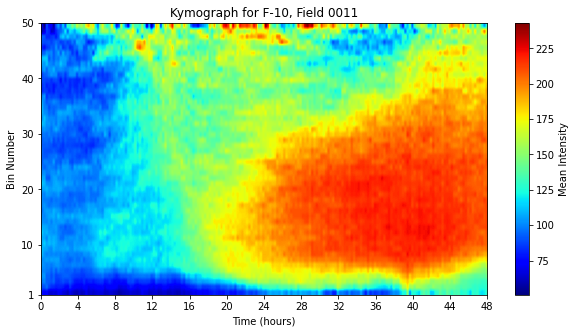

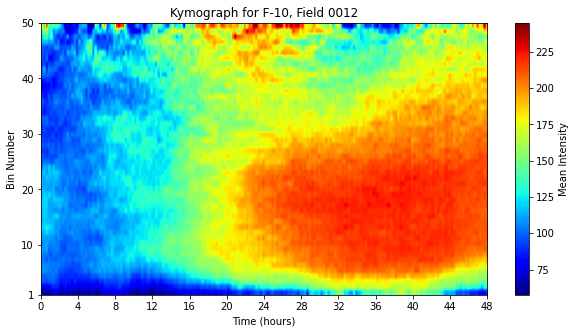

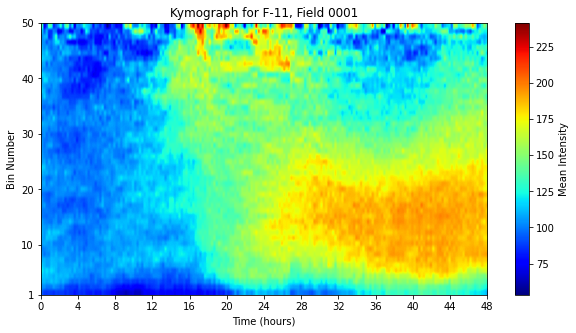

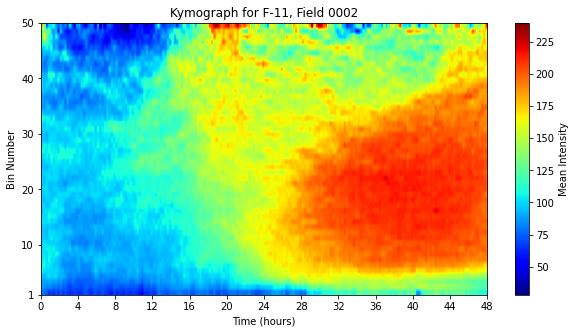

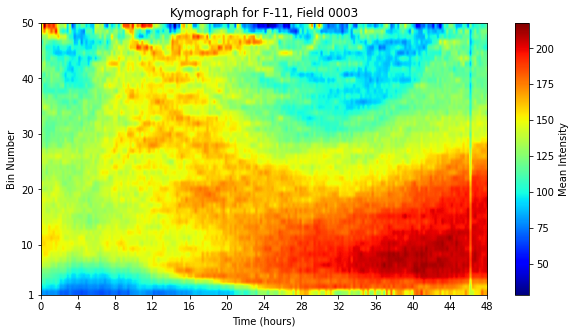

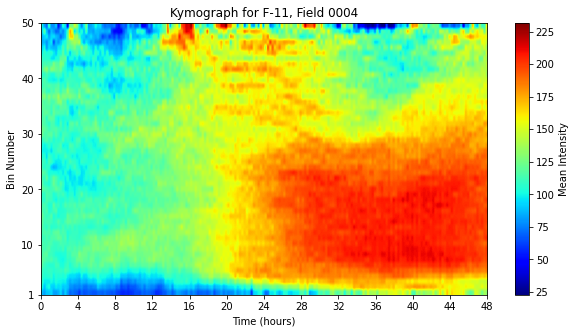

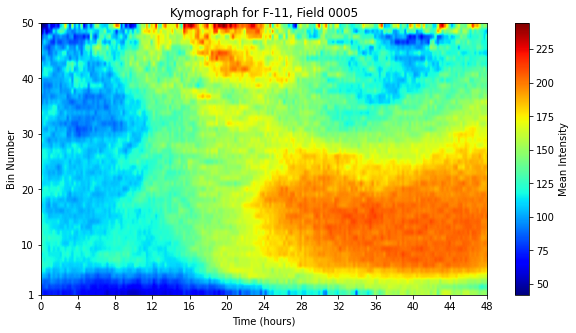

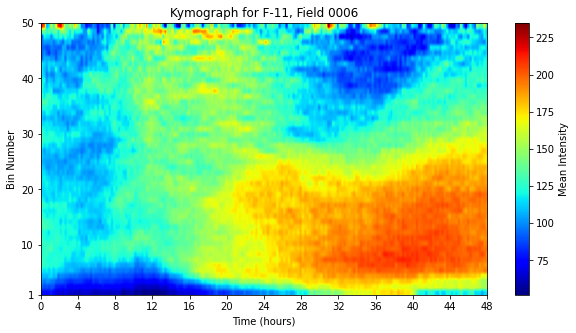

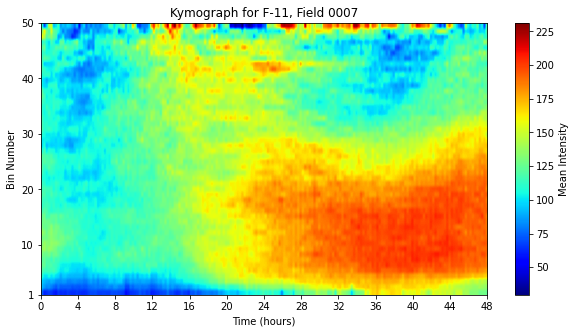

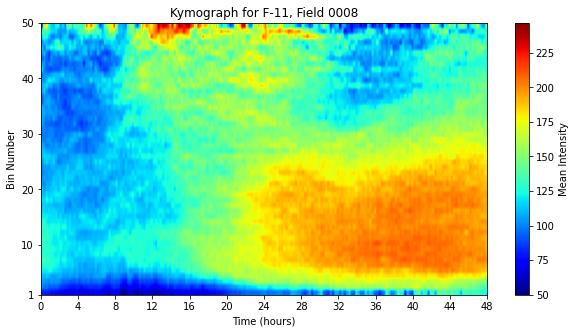

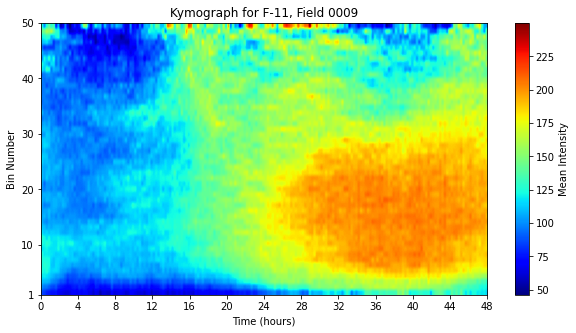

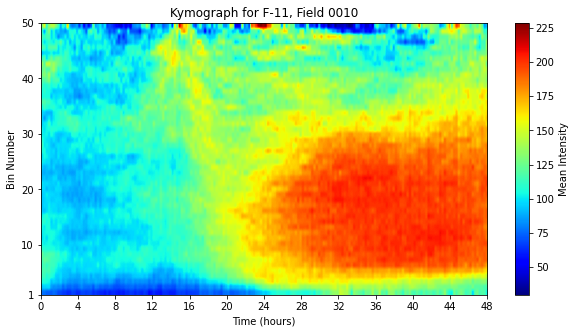

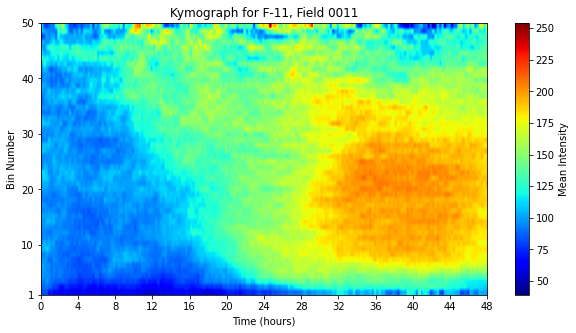

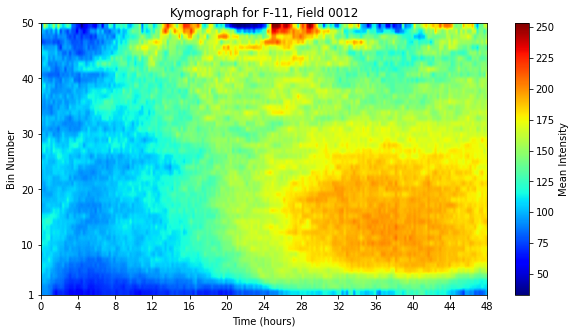

In [63]:
#CREATE KYMOGRAPHS FOR ALL EXPERIMENTS

import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Parameters
scale_pixels_per_um = 3.074 / 2  # corrected due to binning of 2
frame_interval_minutes = 15  # 15 minutes per frame
num_frames = 192
total_duration_hours = frame_interval_minutes * num_frames / 60

# Standardized LUT settings
lower_limit = 27.0
upper_limit = 933.0

# Lower threshold for Canny edge detection
edge_lower_threshold = 10
edge_upper_threshold = 100

# Auto-adjust intensity using standardized LUT settings
def auto_adjust_intensity(image, lower_limit, upper_limit):
    np_image = np.array(image)
    np_image = np.clip(np_image, lower_limit, upper_limit)
    np_image = ((np_image - lower_limit) / (upper_limit - lower_limit) * 255).astype(np.uint8)  # Scale to 8-bit
    return Image.fromarray(np_image)

# Generate masks from the image using improved settings for membrane mask
def generate_masks(image):
    # Convert image to numpy array
    np_image = np.array(image).astype(np.uint8)  # Ensure image is in 8-bit format
    
    # Intensity adjustment
    intensity_adjusted_image = auto_adjust_intensity(image, lower_limit, upper_limit)
    np_image = np.array(intensity_adjusted_image)

    # Identify the primary circle
    blurred = cv2.GaussianBlur(np_image, (5, 5), 0)
    _, colony_mask = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(colony_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    main_contour = max(contours, key=cv2.contourArea)
    ellipse = cv2.fitEllipse(main_contour)
    (x, y), (major_axis, minor_axis), angle = ellipse
    center = (x, y)
    radius = major_axis / 2
    
    colony_mask = np.zeros_like(np_image)
    cv2.circle(colony_mask, (int(center[0]), int(center[1])), int(radius), 255, thickness=-1)
    
    # Adjust the Canny edge detection thresholds relative to the intensity range
    edge_lower_threshold_adj = int((edge_lower_threshold / 255.0) * (upper_limit - lower_limit) + lower_limit)
    edge_upper_threshold_adj = int((edge_upper_threshold / 255.0) * (upper_limit - lower_limit) + lower_limit)
    
    # Generate membrane mask using edge detection and morphological operations
    edges = cv2.Canny(blurred, edge_lower_threshold_adj, edge_upper_threshold_adj)
    kernel = np.ones((3, 3), np.uint8)
    membrane_mask = cv2.dilate(edges, kernel, iterations=1)
    membrane_mask = cv2.erode(membrane_mask, kernel, iterations=1)
    membrane_mask = cv2.morphologyEx(membrane_mask, cv2.MORPH_CLOSE, kernel)
    
    # Generate non-membrane mask by subtracting membrane mask from colony mask
    non_mem_mask = cv2.subtract(colony_mask, membrane_mask)
    
    return Image.fromarray(colony_mask), Image.fromarray(membrane_mask), Image.fromarray(non_mem_mask), center, radius

# Load and process the image for analysis
def load_and_process_image_for_analysis(file_path, non_mem_mask, lower_limit, upper_limit):
    image = Image.open(file_path)
    adjusted_image = auto_adjust_intensity(image, lower_limit, upper_limit)
    
    # Apply non-membrane mask
    image_np = np.array(adjusted_image)
    non_mem_image = Image.fromarray(image_np * (np.array(non_mem_mask) // 255))
    
    return adjusted_image, non_mem_image

# Identify main circular object and create radial bins
def analyze_image(non_mem_image, non_mem_mask, center, radius):
    # Define bin sizes based on the detected radius
    bins = 50
    radial_bins = np.linspace(0, radius, bins + 1)
    
    mean_intensities = []

    non_mem_np = np.array(non_mem_image)
    non_mem_mask_np = np.array(non_mem_mask)
    
    for i in range(bins):
        inner_radius = radial_bins[i]
        outer_radius = radial_bins[i + 1]
        
        # Create a mask for the current bin
        mask = np.zeros_like(non_mem_np, dtype=np.uint8)
        cv2.circle(mask, (int(center[0]), int(center[1])), int(outer_radius), 1, thickness=-1)
        cv2.circle(mask, (int(center[0]), int(center[1])), int(inner_radius), 0, thickness=-1)
        
        # Apply mask to the non-membrane image
        bin_pixels = non_mem_np[mask == 1]
        bin_mask = non_mem_mask_np[mask == 1]
        non_zero_bin_pixels = bin_pixels[bin_mask > 0]  # Exclude zero-value pixels from the non-membrane mask
        if len(non_zero_bin_pixels) > 0:
            mean_intensity = np.mean(non_zero_bin_pixels)
        else:
            mean_intensity = 0
        
        mean_intensities.append(mean_intensity)
    
    return mean_intensities

# Main analysis function for all frames and fields
def analyze_all_fields():
    base_directory = r'C:\Users\josep\Desktop\20240703 48 hour time lapse\TIFFs nonPEG wells\20240707T182811'
    experiments = {
        "D-10": 7,
        "E-09": 12,
        "E-11": 12,
        "F-10": 12,
        "F-11": 12
    }

    all_data = []

    for experiment, num_fields in experiments.items():
        for field in range(1, num_fields + 1):
            kymograph_data = []
            last_valid_data = None

            for frame in range(1, num_frames + 1):
                image_path = os.path.join(base_directory, f'{experiment}_F{field:04d}_T{frame:04d}_Z0001_C01.tif')
                
                if os.path.exists(image_path):
                    # Load original image
                    original_image = Image.open(image_path)
                    # Generate masks for the current frame
                    colony_mask, membrane_mask, non_mem_mask, center, radius = generate_masks(original_image)
                    # Process image with non-membrane mask
                    adjusted_image, non_mem_image = load_and_process_image_for_analysis(image_path, np.array(non_mem_mask), lower_limit, upper_limit)
                    
                    # Perform analysis
                    mean_intensities = analyze_image(non_mem_image, non_mem_mask, center, radius)
                    last_valid_data = mean_intensities
                else:
                    print(f"Image {image_path} does not exist. Using last valid data.")
                    mean_intensities = last_valid_data
                
                kymograph_data.append(mean_intensities)
                all_data.append([experiment, field, frame] + mean_intensities)
            
            # Convert kymograph data to numpy array and transpose it
            kymograph = np.array(kymograph_data).T

            fig, ax = plt.subplots(figsize=(10, 5))
            time_points = np.linspace(0, total_duration_hours, num_frames)
            cax = ax.imshow(kymograph, aspect='auto', cmap='jet', extent=[0, total_duration_hours, 1, 50])
            ax.set_yticks([1, 10, 20, 30, 40, 50])  # Set y-ticks to 1, 10, 20, 30, 40, and 50
            ax.set_yticklabels([1, 10, 20, 30, 40, 50])  # Label y-ticks as 1, 10, 20, 30, 40, and 50
            ax.set_xticks(np.arange(0, total_duration_hours + 1, 4))  # Set x-ticks to represent every 4 hours
            ax.set_xlabel('Time (hours)')
            ax.set_ylabel('Bin Number')
            ax.set_title(f'Kymograph for {experiment}, Field {field:04d}')
            fig.colorbar(cax, label='Mean Intensity')
            plt.show()

    # Convert all_data to a DataFrame and save it to a CSV file
    columns = ['Experiment', 'Field', 'Frame'] + [f'Bin_{i + 1}' for i in range(50)]
    df = pd.DataFrame(all_data, columns=columns)
    df.to_csv('kymograph_data.csv', index=False)

# Perform the analysis
analyze_all_fields()

Shape of kymograph_data for D-10, Field 1: (50, 192)
Shape of kymograph_data for D-10, Field 5: (50, 192)
Shape of kymograph_data for E-09, Field 3: (50, 192)
Shape of kymograph_data for F-10, Field 6: (50, 192)
Shape of kymograph_data for D-10, Field 3: (50, 192)
Shape of kymograph_data for F-10, Field 1: (50, 192)
Shape of kymograph_data for F-10, Field 7: (50, 192)
Shape of kymograph_data for D-10, Field 4: (50, 192)


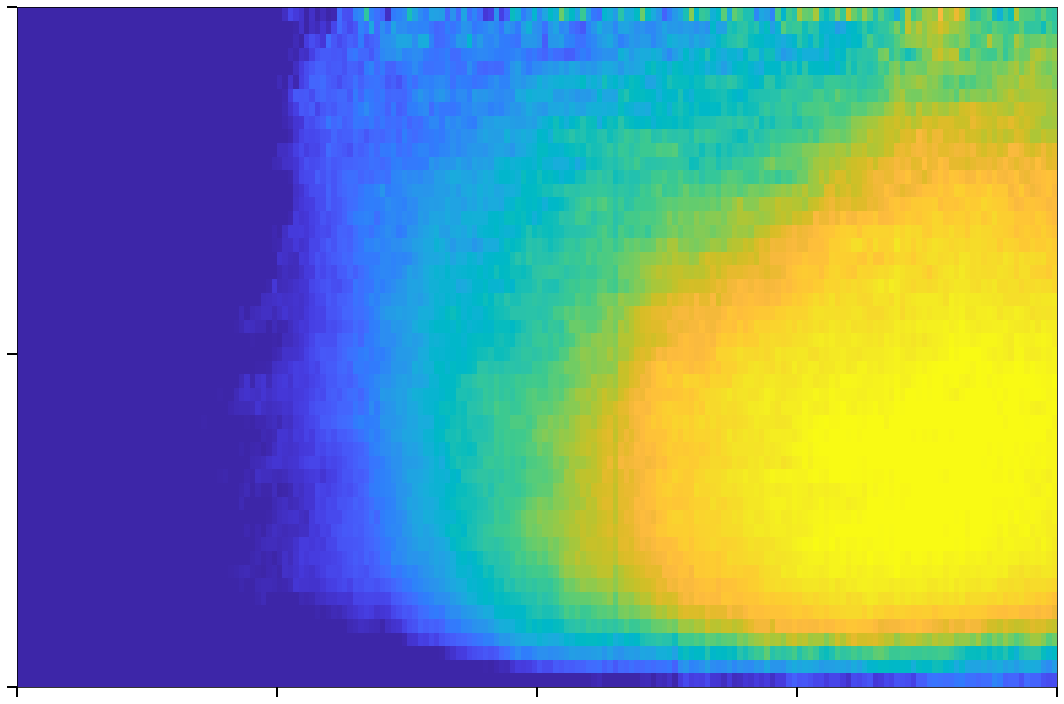

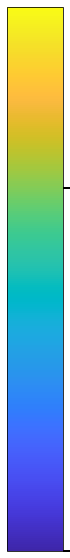

Shape of kymograph_data for F-11, Field 9: (50, 192)
Shape of kymograph_data for E-09, Field 10: (50, 192)
Shape of kymograph_data for F-10, Field 9: (50, 192)
Shape of kymograph_data for E-11, Field 3: (50, 192)
Shape of kymograph_data for E-11, Field 11: (50, 192)
Shape of kymograph_data for F-10, Field 10: (50, 192)
Shape of kymograph_data for E-11, Field 7: (50, 192)
Shape of kymograph_data for E-11, Field 12: (50, 192)


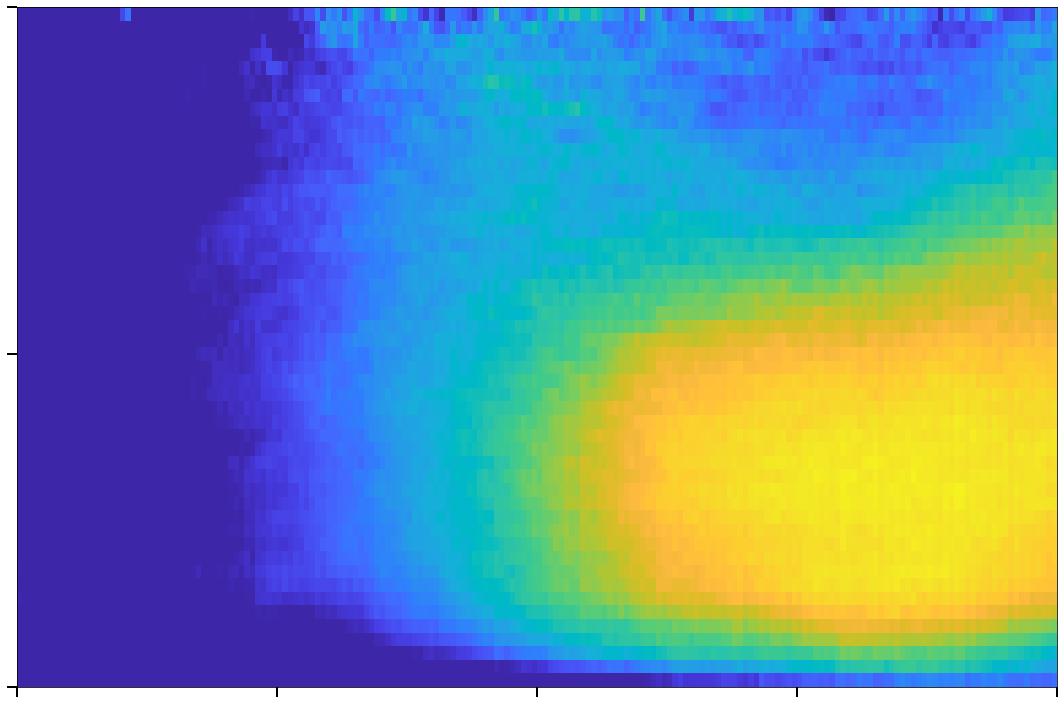

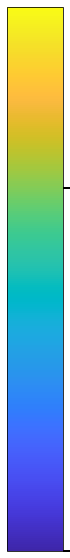

Shape of kymograph_data for F-11, Field 12: (50, 192)
Shape of kymograph_data for E-11, Field 9: (50, 192)
Shape of kymograph_data for F-11, Field 3: (50, 192)
Shape of kymograph_data for E-11, Field 1: (50, 192)
Shape of kymograph_data for F-11, Field 4: (50, 192)
Shape of kymograph_data for F-11, Field 8: (50, 192)
Shape of kymograph_data for F-11, Field 5: (50, 192)
Shape of kymograph_data for F-11, Field 1: (50, 192)


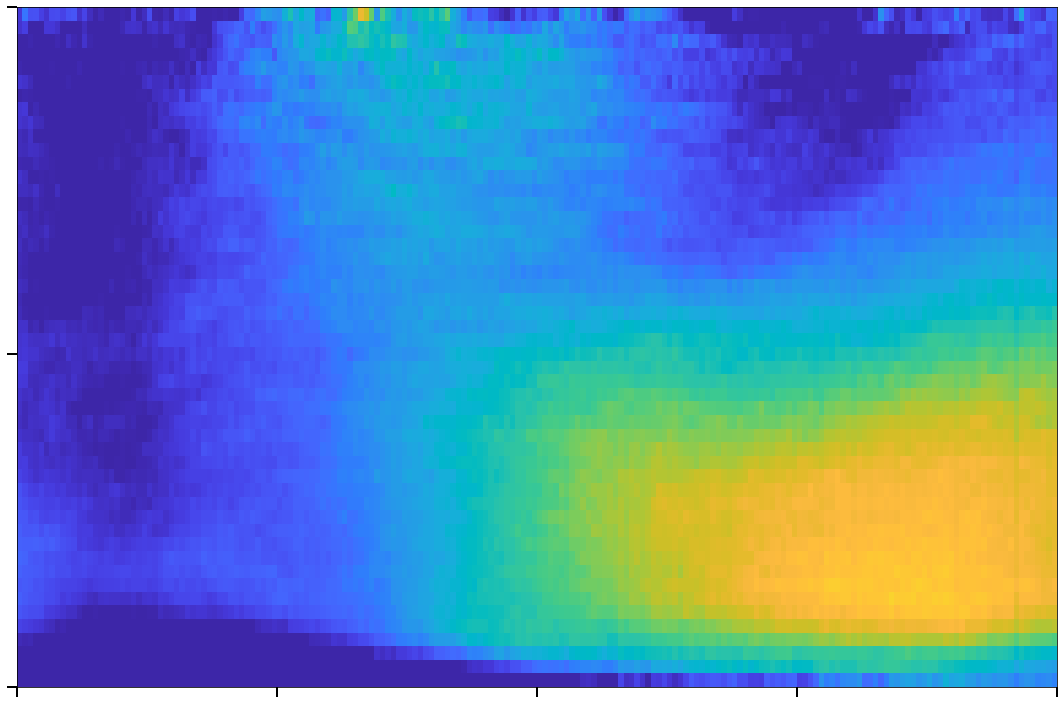

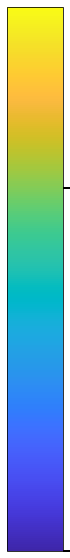

Mean kymographs and color bars for each group saved and displayed successfully.


In [38]:
#CREATE MEAN KYMOGRAPHS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Parameters
frame_interval_minutes = 15  # 15 minutes per frame
num_frames = 192
total_duration_hours = frame_interval_minutes * num_frames / 60

# Load the CSV file
csv_file_path = 'kymograph_data.csv'
data = pd.read_csv(csv_file_path)

# Extract the bin data, ignoring the first three columns
bin_data = data.iloc[:, 3:].values

# Calculate the 25th and 75th percentiles for the entire dataset
percentile_25 = np.percentile(bin_data, 25)
percentile_75 = np.percentile(bin_data, 75)

# Normalize the data using the 25th and 75th percentile values
normalized_data = (bin_data - percentile_25) / (percentile_75 - percentile_25)

# Add normalized data back to the DataFrame
data.iloc[:, 3:] = normalized_data

# Define the groups
low_density = [('D-10', 1), ('D-10', 5), ('E-09', 3), ('F-10', 6), ('D-10', 3), ('F-10', 1), ('F-10', 7), ('D-10', 4)]
medium_density = [('F-11', 9), ('E-09', 10), ('F-10', 9), ('E-11', 3), ('E-11', 11), ('F-10', 10), ('E-11', 7), ('E-11', 12)]
high_density = [('F-11', 12), ('E-11', 9), ('F-11', 3), ('E-11', 1), ('F-11', 4), ('F-11', 8), ('F-11', 5), ('F-11', 1)]

groups = {
    'Low Density': low_density,
    'Medium Density': medium_density,
    'High Density': high_density
}

# Create a directory to save the kymographs
output_dir = 'kymographs_fig3_square'
os.makedirs(output_dir, exist_ok=True)

# Define a consistent color scale range
vmin = 0  # Set to the minimum value of your normalized data if needed
vmax = 1.5  # Set to the maximum value of your normalized data if needed

# Calculate the mean kymograph for each group
for group_name, fields in groups.items():
    kymograph_list = []

    for experiment, field in fields:
        field_data = data[(data['Experiment'] == experiment) & (data['Field'] == field)]
        
        if field_data.empty:
            print(f"No data found for {experiment}, Field {field}")
            continue
        
        kymograph_data = field_data.iloc[:, 3:].values.T
        
        print(f"Shape of kymograph_data for {experiment}, Field {field}: {kymograph_data.shape}")
        kymograph_list.append(kymograph_data)
    
    if not kymograph_list:
        print(f"No valid data found for group {group_name}. Skipping...")
        continue

    # Calculate the mean kymograph
    try:
        mean_kymograph = np.mean(kymograph_list, axis=0)
    except ValueError as e:
        print(f"Error calculating mean kymograph for group {group_name}: {e}")
        continue

    # Plot the mean kymograph
    fig, ax = plt.subplots(figsize=(15, 10))
    time_points = np.linspace(0, total_duration_hours, num_frames)
    cax = ax.imshow(mean_kymograph, aspect='auto', cmap='jet', extent=[0, total_duration_hours, 1, 50], vmin=vmin, vmax=vmax)
    
    # Set y-ticks for 1, 25, 50 bins
    ax.set_yticks([1, 25, 50])
    ax.tick_params(axis='y', length=10, width=2)  # Make y-tick marks thicker
    ax.set_yticklabels([])  # Remove y-tick labels

    # Set x-ticks for 0, 12, 24, 36, 48 hours
    ax.set_xticks([0, 12, 24, 36, 48])
    ax.tick_params(axis='x', length=10, width=2)  # Make x-tick marks thicker
    ax.set_xticklabels([])  # Remove x-tick labels
    
    # Adjust layout to prevent labels from being cut off
    fig.tight_layout()

    # Save the kymograph in high resolution
    kymograph_path = os.path.join(output_dir, f'{group_name.replace(" ", "_").lower()}_mean_kymograph.png')
    plt.savefig(kymograph_path, dpi=300, bbox_inches='tight')  # Save at 300 dpi for high resolution

    # Display the kymograph
    plt.show()

    # Create a separate figure for the color bar
    fig, cbar_ax = plt.subplots(figsize=(1, 10))  # Adjust the size as needed
    cbar = fig.colorbar(cax, cax=cbar_ax)
    cbar.set_ticks([0.0, 1.0])  # Set specific ticks for the color bar
    cbar.ax.yaxis.set_tick_params(length=10, width=2)  # Make cbar tick marks thicker
    cbar.ax.set_yticklabels([])  # Remove color bar tick labels
    cbar.set_label('', fontsize=0)  # Ensure no label is present

    # Save the color bar in high resolution
    cbar_path = os.path.join(output_dir, f'{group_name.replace(" ", "_").lower()}_mean_kymograph_cbar.png')
    plt.savefig(cbar_path, dpi=300, bbox_inches='tight')  # Save at 300 dpi for high resolution

    # Display the color bar
    plt.show()

print("Mean kymographs and color bars for each group saved and displayed successfully.")